# Morphology Prediction Analysis Notebook

## Setup

In [15]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

!export PYTHONWARNINGS="ignore"

import warnings
warnings.filterwarnings(action="ignore", message="unclosed", category=ResourceWarning)
warnings.filterwarnings('error', category=DeprecationWarning)
warnings.filterwarnings('ignore')

import os
import pandas as pd
from glob import glob
import numpy as np
import warnings
warnings.filterwarnings("always")
import matplotlib.pyplot as plt
from random import shuffle
import time
import yaml
import json
import seaborn as sns
from tqdm import tqdm
import sys
import torch
print(torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.get_device_name(0))
import torchvision.utils as vutils
from torchviz import make_dot, make_dot_from_trace
import cv2
from scipy.ndimage import zoom
import torch.nn.functional as F

import utils.util as bmUtil
from utils.const import StainChannel, ModelType, Phase, Dataset
from utils.data.preprocessing import BMPreprocessing as bmPrep
from analysis.morphologyPredictor import MorphologyPredictor, build_args

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True 0 NVIDIA TITAN RTX


## Load Data

In [168]:
# Plot save dir
save_dir = '/media/ssdshare2/general/MYK/data/analysis/subclustering'
class_id = 2

# CKp25 - ALTR
#wd_ckp25 = '/media/share/MYK/beegfs/found/CKp25_45110/inference/20240408-1948_CKp25_45110_IBA1/prediction/ALTR-20210914-234831-bumblebee'
sample_dpath = os.path.join(wd, str(class_id))
print("sample_dpath: ", sample_dpath)

sample_dpath:  /media/share/MYK/beegfs/found/CKp25_45110/inference/20240408-1948_CKp25_45110_IBA1/prediction/ALTR-20210914-234831-bumblebee/2


In [143]:
sample_data = glob("%s/*/*dzfeat.npy"%sample_dpath)
shuffle(sample_data)
len(sample_data)

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


885386

In [186]:
# CK - ALTR
wd_ck = '/media/ssdshare2/general/MYK/data/TsaiLab_data/20211111_15_37_13_AD_CK_LH_43992_10x_561LP65_642LP80/inference/20240408-1938_20211111_15_37_13_AD_CK_LH_43992_10x_561LP65_642LP80_IBA1/prediction/ALTR-20210914-234831-bumblebee'
sample_dpath_ck = os.path.join(wd_ck, str(class_id))
sample_data_ck = glob("%s/*/*dzfeat.npy"%sample_dpath_ck)
shuffle(sample_data_ck)
len(sample_data_ck)

1718130

In [187]:
def load_features(data, up_to=10000):
    
    rn_dict = {'cid': [], 'z': [], 'y': [], 'x': [], 'feat': [], 'raw': []}
    dz_dict = {'cid': [], 'z': [], 'y': [], 'x': [], 'feat': []}
    for idx, sd in enumerate(tqdm(data[:up_to], "loading...")):
        #print("sd: ", sd)
        #print("rnf: ", rnf, "coord: ", coord)
        rnf = '_'.join(sd.split('_')[:-1]) + "_rnfeat.npy"
        rawf = '_'.join(sd.split('_')[:-1]) + ".npy"
        coord = [int(i) for i in os.path.basename(sd).split('_')[3].split('-')[2:]]

        dz_feat = np.load(sd)
        rn_feat = np.load(rnf)
        raw_data = np.load(rawf)
        #print("dz feat shape: ", dz_feat.shape, "rn feat shape: ", rn_feat.shape, raw_data.shape)

        #RN
        rn_dict['cid'].append(idx)
        rn_dict['z'].append(coord[0])
        rn_dict['y'].append(coord[1])
        rn_dict['x'].append(coord[2])
        rn_dict['feat'].append(rn_feat)
        rn_dict['raw'].append(raw_data)

        #DZ
        dz_dict['cid'].append(idx)
        dz_dict['z'].append(coord[0])
        dz_dict['y'].append(coord[1])
        dz_dict['x'].append(coord[2])
        dz_dict['feat'].append(dz_feat)
        
    return rn_dict, dz_dict

In [188]:
UP_TO=50000

#rn_dict_ckp25 = rn_dict
#dz_dict_ckp25 = dz_dict
#rn_dict_ckp25, dz_dict_ckp25 = load_features(sample_data, up_to=UP_TO)

rn_dict_ck, dz_dict_ck = load_features(sample_data_ck, up_to=UP_TO)

loading...: 100%|██████████| 50000/50000 [05:16<00:00, 157.94it/s]


## Fitting

In [253]:
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
#from scipy.optimize import curve_fit, minimize_scalar
from sklearn.metrics import silhouette_score
from analysis.unsupervisedLearner import BMClustering
import matplotlib as mpl
mpl.rc('image', cmap="viridis")

def fit_KMenas(data_dict, upto, feat1_idx=100, feat2_idx=400, cm='viridis'):
    km_cids = [ii for ii in range(sum(upto))]
    km_feats = []
    km_raws = []
    for i in range(len(data_dict)):
        km_feat = data_dict[i]['feat'][:upto[i]]
        km_raw = data_dict[i]['raw'][:upto[i]]
        km_cid = [j for j in range(len(km_feat))]
        
        km_raws += km_raw
        km_feats += km_feat
    
    km_feats = np.array(km_feats)
    km_cids = np.array(km_cids)
    km_raws = np.array(km_raws)
    
    #km_feats = np.array(data_dict['feat'][:UP_TO])
    #km_cids = np.array(data_dict['cid'][:UP_TO])
    #km_raws = np.array(data_dict['raw'][:UP_TO])
    print(km_feats.shape, km_cids.shape)
    
    bmc = BMClustering()
    bmc.set_data(km_feats, km_cids)
    preds, cells_picked = bmc.run_kmeans(max_nc=MAX_K, cm='brg', viz=True, figsize=(5, 5), save_path=save_dir)
    
    bmc.set_feat_pair(feat1_idx=feat1_idx, feat2_idx=feat2_idx)
    fig = bmc.viz_kmeans_result(preds, figsize=(10,10), cm=cm)
    
    for i in range(len(cells_picked)):
        fig = bmc.viz_cell(km_raws, cells_picked[i], "Sub-class %d"%i, figsize=(12, 5))
        fig.tight_layout()
    
    return bmc, preds, cells_picked, km_raws

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Feat KMeans

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10000, 1024) (10000,)


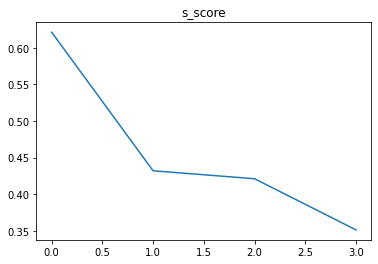

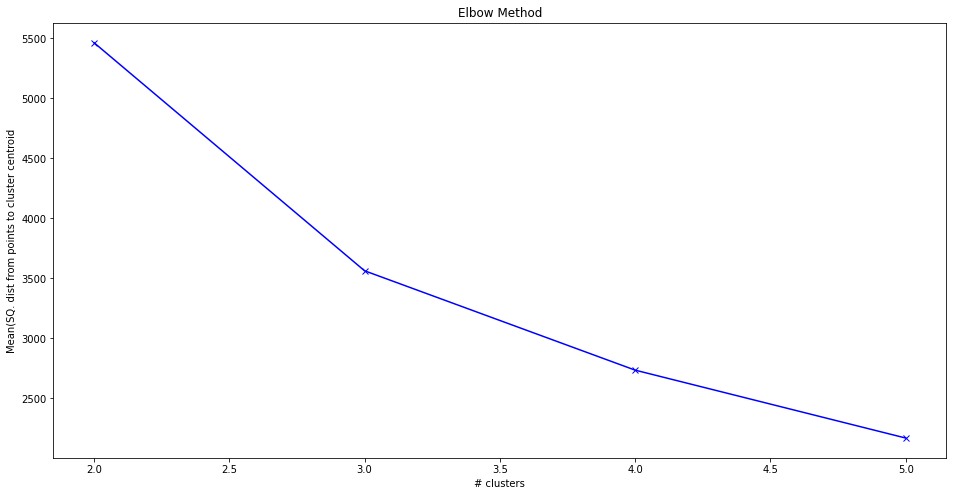

k_det:  4 , elbow index:  3
determine_K(): saved silhouette_scores to /media/ssdshare2/general/MYK/data/analysis/subclustering/silhouette_scores_2024-04-22_033612.csv
determine_K(): saved elbow indices to /media/ssdshare2/general/MYK/data/analysis/subclustering/elbow_indices_2024-04-22_033612.csv


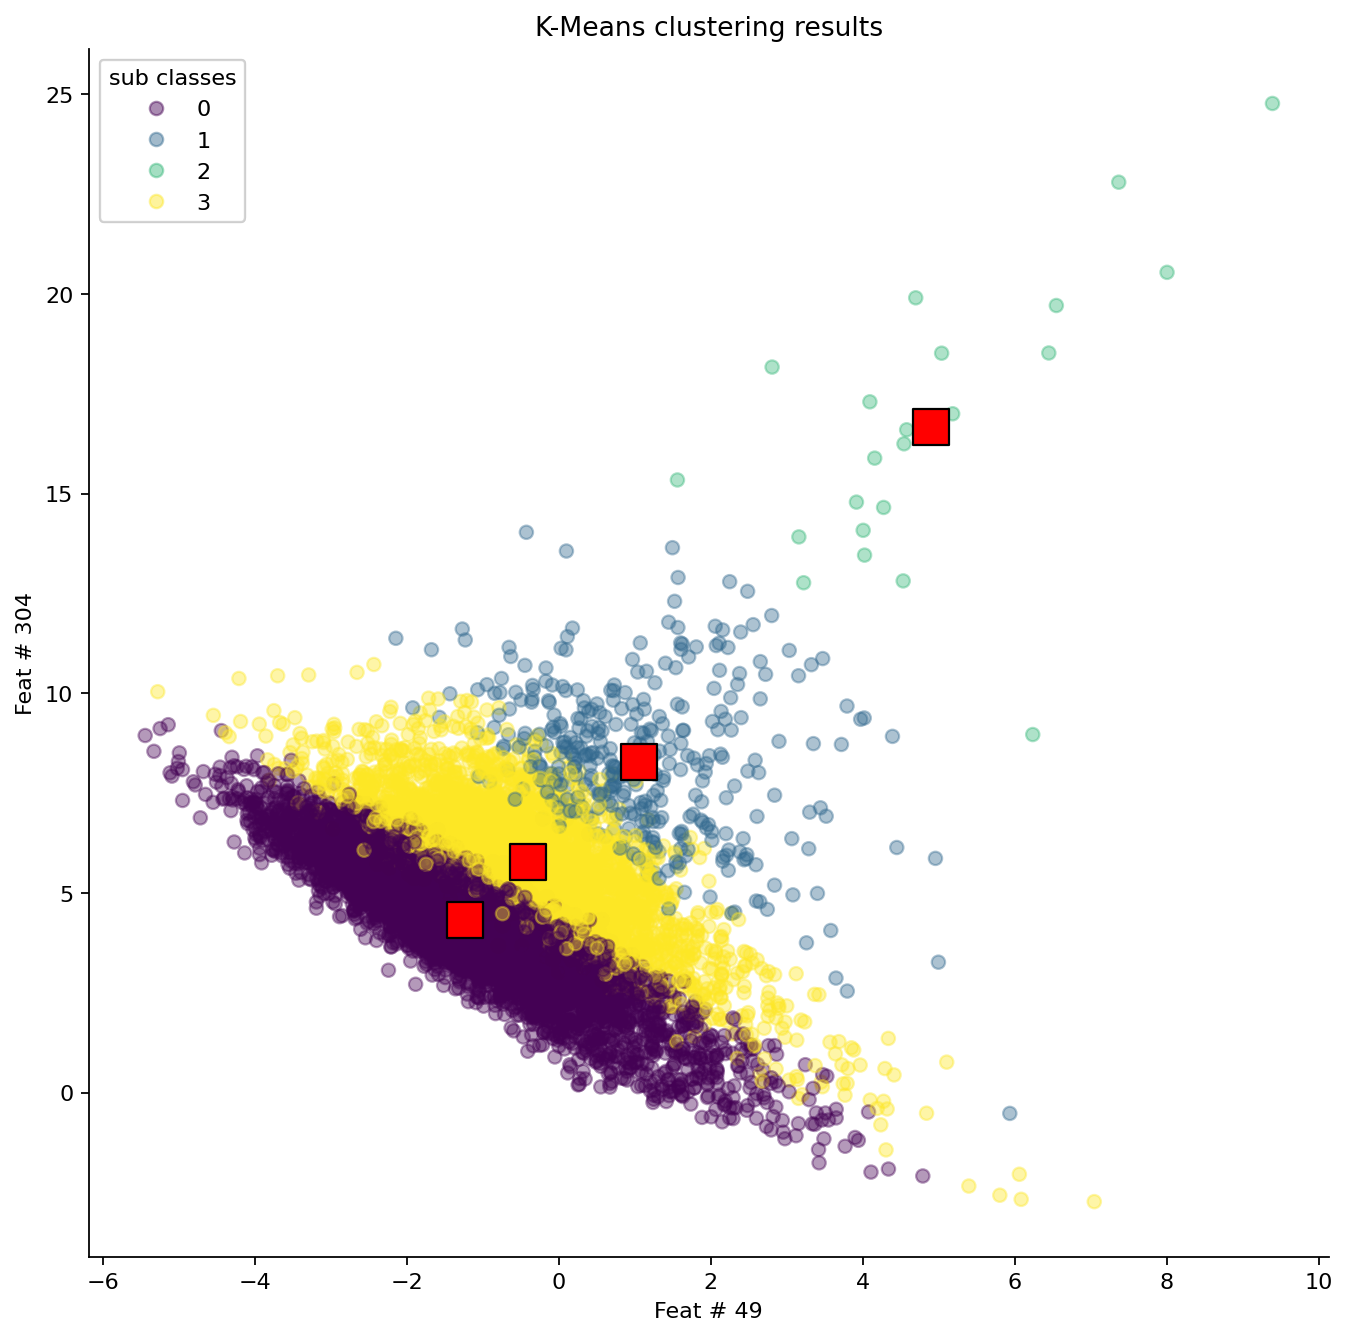

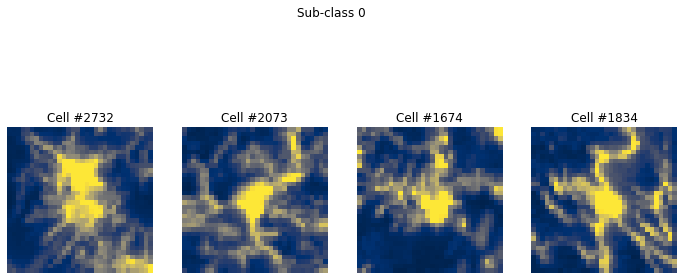

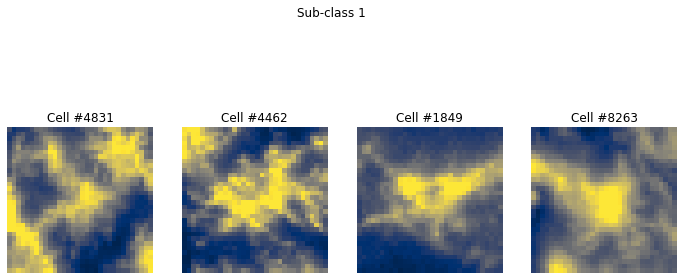

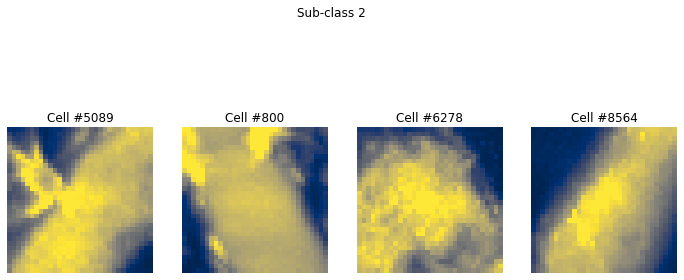

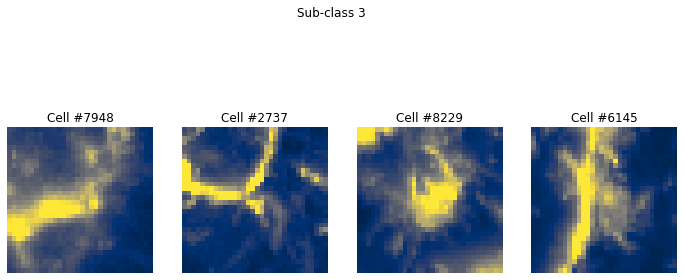

In [290]:
MAX_K=5
#upto = [20000, 20000]
upto = [10000]
save_model = False

if False:
    #Train with RN Feature
    bmc_rn, preds_rn = fit_KMenas([rn_dict_ckp25, rn_dict_ck], upto=upto, feat1_idx=100, feat2_idx=400, cm='viridis')
    if save_model:
        # Save Model
        now = bmUtil.get_current_time()
        model_name = "KMeans-%s-CK_CKp25_RN_NumSample_%s_K_%d"%(now, '_'.join([str(u) for u in upto]), bmc_rn.k_det)
        bmc_rn.save_model(save_dir, model_name)
else:
    #Train with DZ Feature
    #dz_dict_ckp25['raw'] = rn_dict_ckp25['raw']
    #dz_dict_ck['raw'] = rn_dict_ck['raw']
    #bmc_dz = fit_KMenas([dz_dict_ckp25, dz_dict_ck], upto=upto, feat1_idx=49, feat2_idx=304, cm='viridis')
    bmc_dz, preds_dz, cells_picked, km_raws = fit_KMenas([dz_dict_ckp25], upto=upto, feat1_idx=49, feat2_idx=304, cm='viridis')
    if save_model:
        # Save Model
        now = bmUtil.get_current_time()
        model_name = "KMeans-%s-CK_CKp25_DZ_NumSample_%s_K_%d"%(now, '_'.join([str(u) for u in upto]), bmc_dz.k_det)
        bmc_dz.save_model(save_dir, model_name)